In [1]:
import sys, os

In [2]:
sys.path.extend([os.path.abspath('../../../../')])

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Recovering the result of De Cruz, Demaeyer and Vannitsem (2016)

In this example, we recover the attractor shown in

* De Cruz, L., Demaeyer, J. and Vannitsem, S. (2016). *The Modular Arbitrary-Order Ocean-Atmosphere Model: MAOOAM v1.0*, Geosci. Model Dev., **9**, 2793-2808. [doi:10.5194/gmd-9-2793-2016](https://doi.org/10.5194/gmd-9-2793-2016)

obtained with a 2-layer channel QG atmosphere truncated at wavenumber 2 coupled, both by friction and heat exchange, to a shallow water ocean with 8 modes. 


## Modules import

Loading of some modules...

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Initializing the random number generator (for reproducibility). -- Disable if needed.

In [5]:
np.random.seed(21217)

Importing the model's modules

In [6]:
from qgs.params.params import QgParams
from qgs.integrators.integrator import RungeKuttaIntegrator
from qgs.functions.tendencies import create_tendencies

and diagnostics

In [7]:
from qgs.diagnostics.streamfunctions import MiddleAtmosphericStreamfunctionDiagnostic, OceanicLayerStreamfunctionDiagnostic
from qgs.diagnostics.temperatures import MiddleAtmosphericTemperatureDiagnostic, OceanicLayerTemperatureDiagnostic
from qgs.diagnostics.variables import VariablesDiagnostic, GeopotentialHeightDifferenceDiagnostic
from qgs.diagnostics.multi import MultiDiagnostic

## Systems definition

General parameters

In [8]:
# Time parameters
dt = 0.1
# Saving the model state n steps
write_steps = 10

number_of_trajectories = 1

Setting some model parameters

In [9]:
# Model parameters instantiation with some non-default specs
model_parameters = QgParams()

# Mode truncation at the wavenumber 2 in both x and y spatial
# coordinates for the atmosphere
model_parameters.set_atmospheric_channel_fourier_modes(2, 2)
# Mode truncation at the wavenumber 2 in the x and at the 
# wavenumber 4 in the y spatial coordinates for the ocean
model_parameters.set_oceanic_basin_fourier_modes(2, 4)

In [10]:
# Setting MAOOAM parameters according to the publication linked above
model_parameters.set_params({'kd': 0.0290, 'kdp': 0.0290, 'n': 1.5, 'r': 1.e-7,
                             'h': 136.5, 'd': 1.1e-7})
model_parameters.atemperature_params.set_params({'eps': 0.7, 'T0': 289.3,
                                                 'hlambda': 15.06})
model_parameters.gotemperature_params.set_params({'gamma': 5.6e8, 'T0': 301.46})

Setting the short-wave radiation component as in the publication above: $C_{\text{a},1}$ and $C_{\text{o},1}$ 


In [11]:
model_parameters.atemperature_params.set_insolation(103.3333, 0)
model_parameters.gotemperature_params.set_insolation(310, 0)

Printing the model's parameters

In [12]:
model_parameters.print_params()

Qgs parameters summary

General Parameters:
'time_unit': days,
'rr': 287.058  [J][kg^-1][K^-1]  (gas constant of dry air),
'sb': 5.67e-08  [J][m^-2][s^-1][K^-4]  (Stefan-Boltzmann constant),

Scale Parameters:
'scale': 5000000.0  [m]  (characteristic space scale (L*pi)),
'f0': 0.0001032  [s^-1]  (Coriolis parameter at the middle of the domain),
'n': 1.5    (aspect ratio (n = 2 L_y / L_x)),
'rra': 6370000.0  [m]  (earth radius),
'phi0_npi': 0.25    (latitude expressed in fraction of pi),
'deltap': 50000.0  [Pa]  (pressure difference between the two atmospheric layers),

Atmospheric Parameters:
'kd': 0.029  [nondim]  (atmosphere bottom friction coefficient),
'kdp': 0.029  [nondim]  (atmosphere internal friction coefficient),
'sigma': 0.2  [nondim]  (static stability of the atmosphere),

Atmospheric Temperature Parameters:
'gamma': 10000000.0  [J][m^-2][K^-1]  (specific heat capacity of the atmosphere),
'C[1]': 103.3333  [W][m^-2]  (spectral component 1 of the short-wave radiation of the 

Creating the tendencies function

In [13]:
f, Df = create_tendencies(model_parameters)

## Time integration and plotting a section of the attractor

Defining an integrator

In [14]:
integrator = RungeKuttaIntegrator()
integrator.set_func(f)

Start on a random initial condition and integrate over a transient time to obtain an initial condition on the attractors (may take several minutes)

In [15]:
## Might take several minutes, depending on your cpu computational power.
ic = np.random.rand(model_parameters.ndim)*0.01
integrator.integrate(0., 10000000., dt, ic=ic, write_steps=0)
time, ic = integrator.get_trajectories()

Now integrate to obtain a trajectory on the attractor

In [16]:
integrator.integrate(0., 1000000., dt, ic=ic, write_steps=write_steps)
time, traj = integrator.get_trajectories()

and plot $\psi_1^{\rm a}$, $\psi_2^{\rm o}$ and $\theta_2^{\rm o}$

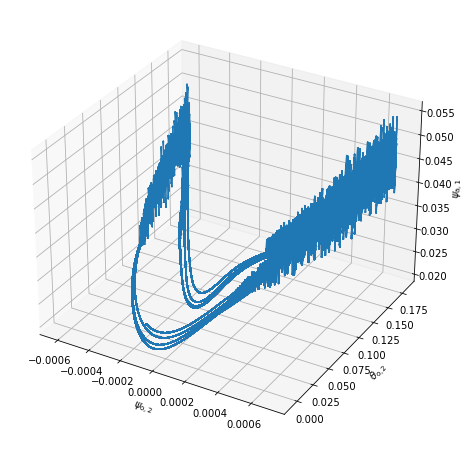

In [17]:
fig = plt.figure(figsize=(10, 8))
axi = fig.gca(projection='3d')

axi.scatter(traj[21], traj[29], traj[0], s=0.2);

axi.set_xlabel('$'+model_parameters.latex_var_string[21]+'$')
axi.set_ylabel('$'+model_parameters.latex_var_string[29]+'$')
axi.set_zlabel('$'+model_parameters.latex_var_string[0]+'$');

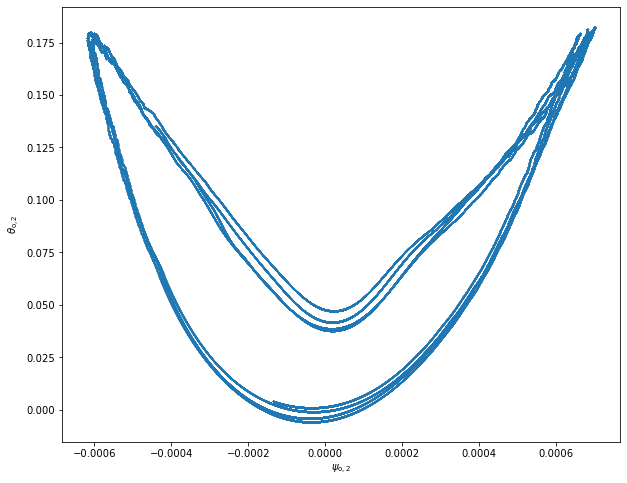

In [18]:
varx = 21
vary = 29
plt.figure(figsize=(10, 8))

plt.plot(traj[varx], traj[vary], marker='o', ms=0.1, ls='')

plt.xlabel('$'+model_parameters.latex_var_string[varx]+'$')
plt.ylabel('$'+model_parameters.latex_var_string[vary]+'$');

## Showing the resulting fields

One can use objects called `Diagnostic` to plot movies of the model fields.
Here we show how to use them and plot the simultaneous time evolution of the variables $\psi_{{\rm a}, 1}$, $\psi_{{\rm o}, 2}$ and $\theta_{{\rm o}, 2}$, with the corresponding atmospheric and oceanic streamfunctions and temperature at 500 hPa.

First, we create the diagnostics:

* For the 500hPa geopotential height:

In [19]:
psi_a = MiddleAtmosphericStreamfunctionDiagnostic(model_parameters, geopotential=True)

* For the 500hPa atmospheric temperature:

In [20]:
theta_a = MiddleAtmosphericTemperatureDiagnostic(model_parameters)

* For the ocean streamfunction:

In [21]:
psi_o = OceanicLayerStreamfunctionDiagnostic(model_parameters)

* For the ocean temperature:

In [22]:
theta_o = OceanicLayerTemperatureDiagnostic(model_parameters)

* For the nondimensional variables $\psi_{{\rm a}, 1}$, $\psi_{{\rm o}, 2}$ and $\theta_{{\rm o}, 2}$:

In [23]:
variable_nondim = VariablesDiagnostic([21, 29, 0], model_parameters, False)

* For the geopotential height difference between North and South:

In [24]:
geopot_dim = GeopotentialHeightDifferenceDiagnostic([[[np.pi/model_parameters.scale_params.n, np.pi/4], [np.pi/model_parameters.scale_params.n, 3*np.pi/4]]],
                                                    model_parameters, True)


In [25]:
# setting also the background
background = VariablesDiagnostic([21, 29, 0], model_parameters, False)
background.set_data(time, traj)

and we select a subset of the data to plot:

In [26]:
stride = 10
sel_time = time[10000:10000+5200*stride:stride]
sel_traj = traj[:, 10000:10000+5200*stride:stride]

We then create a multi diagnostic with all the diagnostics:

In [27]:
m = MultiDiagnostic(3,2)
m.add_diagnostic(geopot_dim, diagnostic_kwargs={'style':'moving-timeserie'})
m.add_diagnostic(variable_nondim, diagnostic_kwargs={'show_time':False, 'background': background, 'style':'3Dscatter'}, plot_kwargs={'ms': 0.2})
m.add_diagnostic(theta_a, diagnostic_kwargs={'show_time':False})
m.add_diagnostic(psi_a, diagnostic_kwargs={'show_time':False})
m.add_diagnostic(theta_o, diagnostic_kwargs={'show_time':False})
m.add_diagnostic(psi_o, diagnostic_kwargs={'show_time':False})

m.set_data(sel_time, sel_traj)

and create the movie:

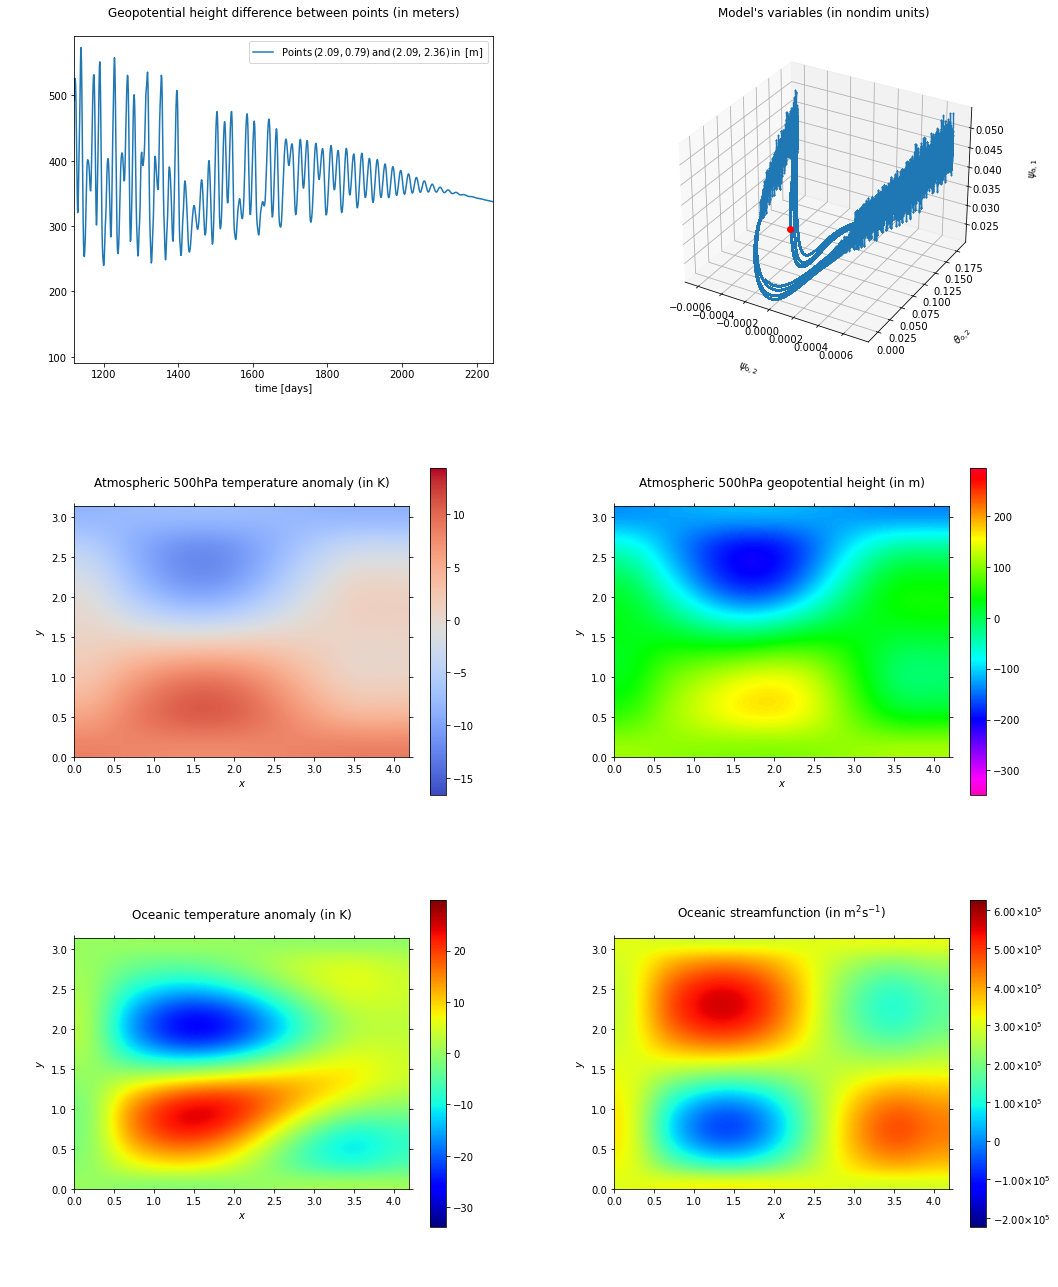

In [28]:
m.movie(figsize=(15,18), anim_kwargs={'interval': 100, 'frames':1000})